ΟΝΟΜΑΤΕΠΩΝΥΜΑ: ΑΠΟΣΤΟΛΟΣ ΚΑΡΒΕΛΑΣ / ΙΩΑΝΝΗΣ ΠΑΠΑΔΗΜΗΤΡΙΟΥ  
ΑΜ: 1115201800312 / 1115201800150


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import matplotlib 
import numpy as np
from pandas import DataFrame
%matplotlib inline 
import heapq
import datetime
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance
import nltk
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec
from sklearn.naive_bayes import GaussianNB
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn import preprocessing
import gensim.downloader as api




Μετατρέπουμε τα 2 csv αρχεία σε pandas dataframes.

In [ ]:
true_df = pd.read_csv(r'/content/gdrive/MyDrive/DICources/True.csv')  
fake_df=pd.read_csv(r'/content/gdrive/MyDrive/DICources/Fake.csv')

**1.1** Cleanup

In [ ]:

#True df cleanup
true_df.dropna() #remove null
for col in true_df.columns:
    true_df[col]=true_df[col].str.replace('[^\w\s]', '') #remove punctuation 
    true_df[col]=true_df[col].str.lower() #make all letters uniform 
#Fake df cleanup
#same as above
fake_df.dropna()
for col in fake_df.columns:
    fake_df[col]=fake_df[col].str.replace('[^\w\s]', '')
    fake_df[col]=fake_df[col].str.lower()


# 1.2.a  
Βρίσκουμε τις 20 πιο συνήθεις λέξεις, αφαιρώντας τα stopwords.

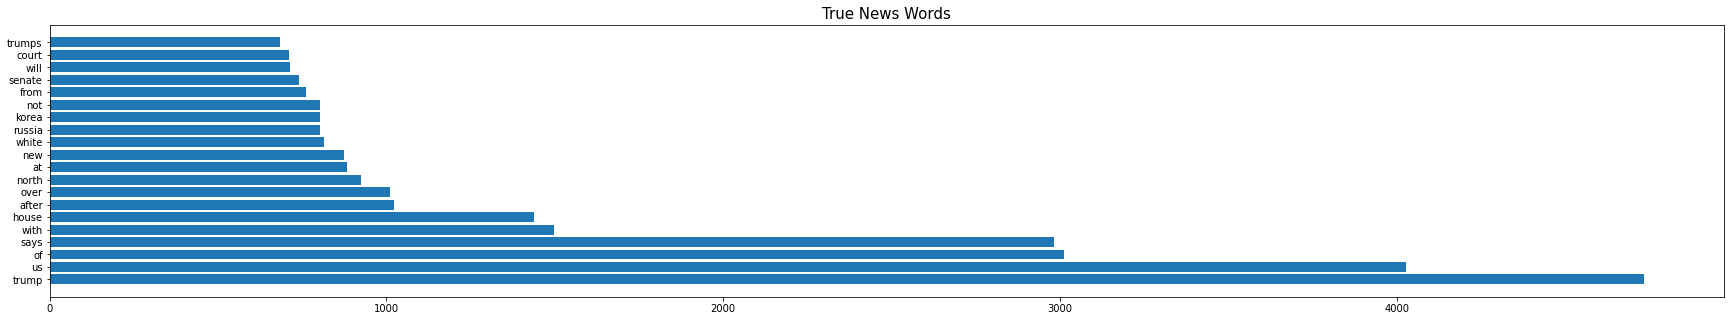

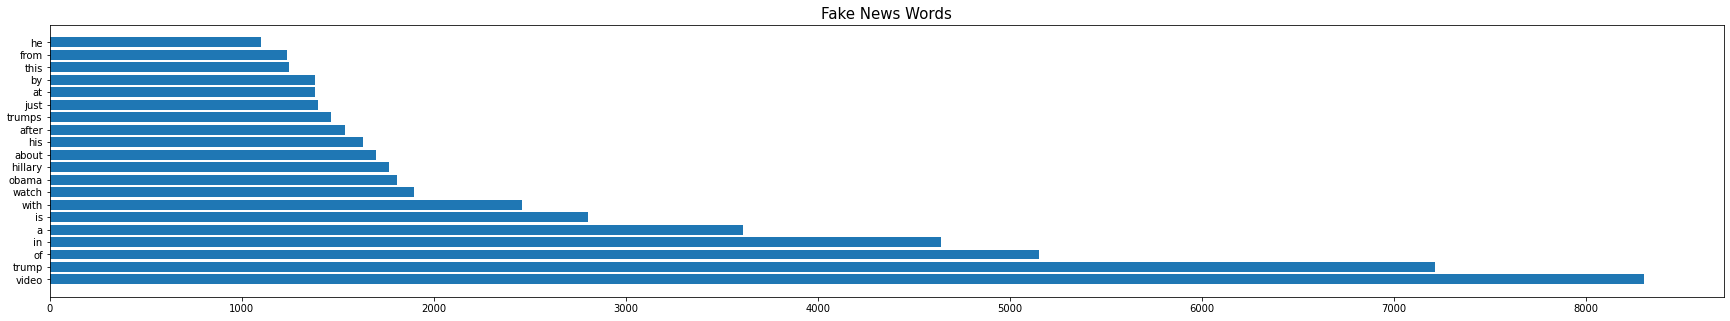

In [ ]:
stopwords = ['the','of','a','and','to','in','on','as','an','for','is','^']


#true
most_used_words_true=Counter(" ".join(true_df["title"]).split()).most_common(100)
for l in most_used_words_true:
  if l[0] in stopwords:
    most_used_words_true.remove(l)
most_used_words_true=most_used_words_true[:20]

#fake
most_used_words_fake=Counter(" ".join(fake_df["title"]).split()).most_common(100)
for l in most_used_words_fake:
  if l[0] in stopwords:
    most_used_words_fake.remove(l)
most_used_words_fake=most_used_words_fake[:20]


#graph
fig,ax = plt.subplots()
fig.set_size_inches(30,5)
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)

plt.title('True News Words', fontsize=15)
plt.barh(*zip(*most_used_words_true))
plt.show()  

fig,ax = plt.subplots()
fig.set_size_inches(30,5)
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)

plt.title('Fake News Words', fontsize=15)
plt.barh(*zip(*most_used_words_fake))
plt.show()  


# 1.2.b 
Φτιάχνουμε ένα dictionary και για κάθε χαρακτήρα που βρίσκουμε αυξάνουμε την αντίστοιχη τιμή του κατά 1.

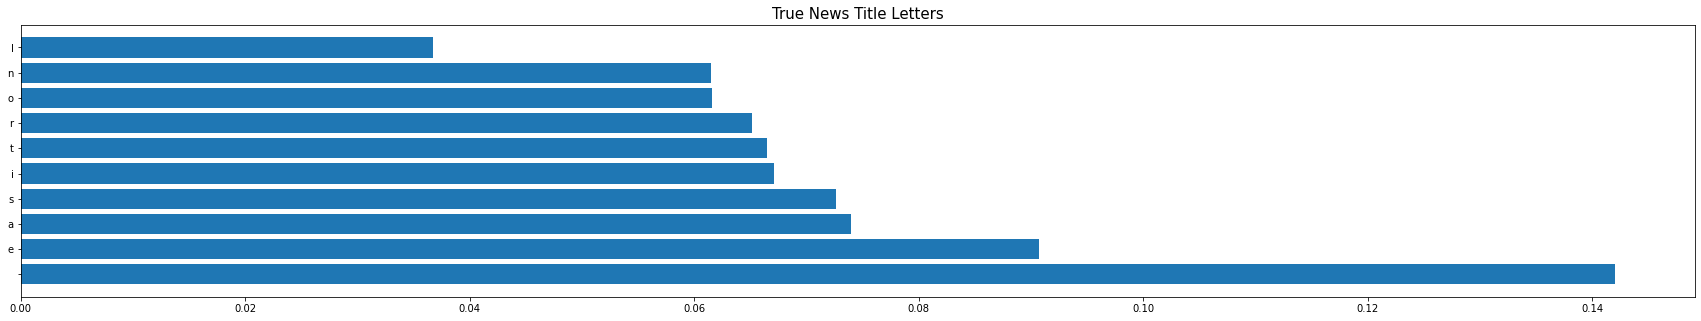

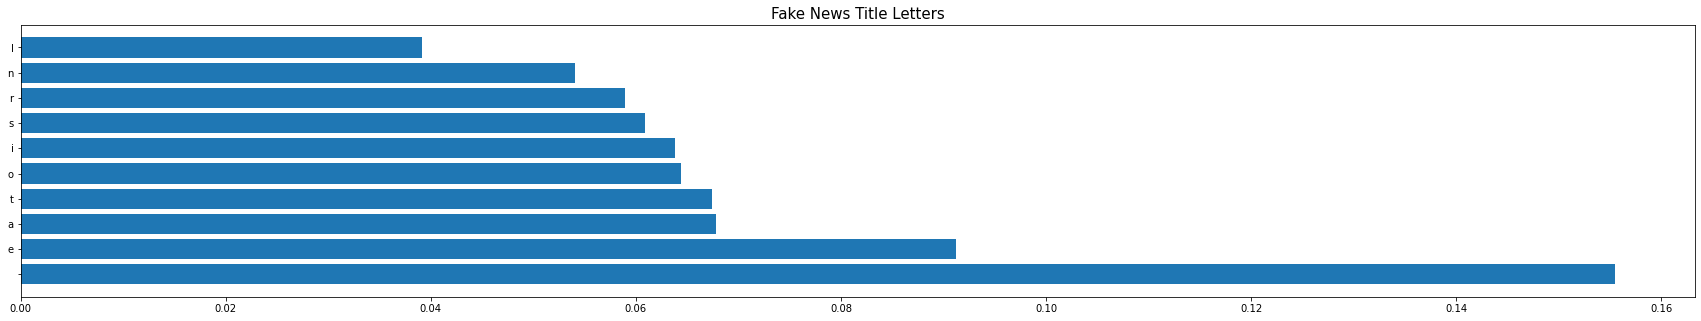

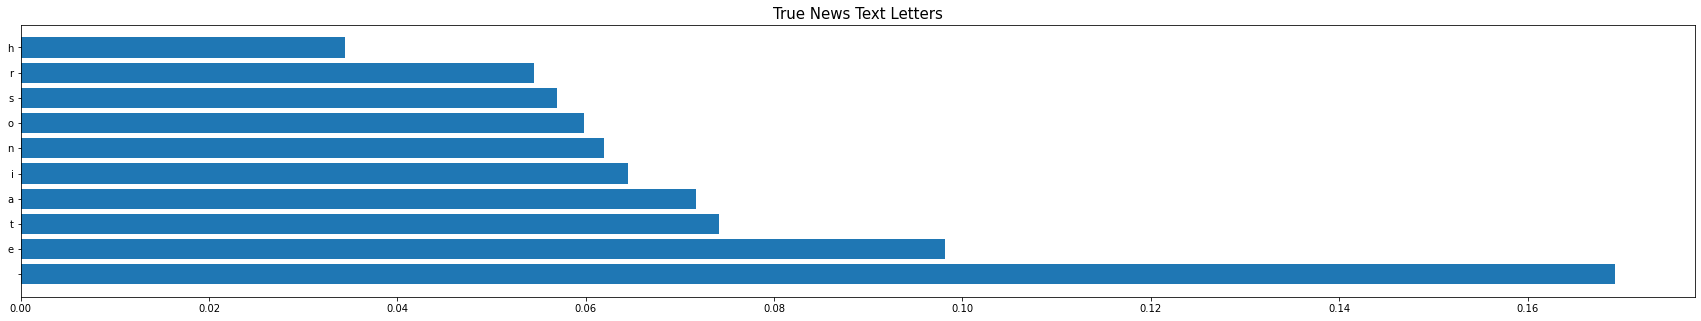

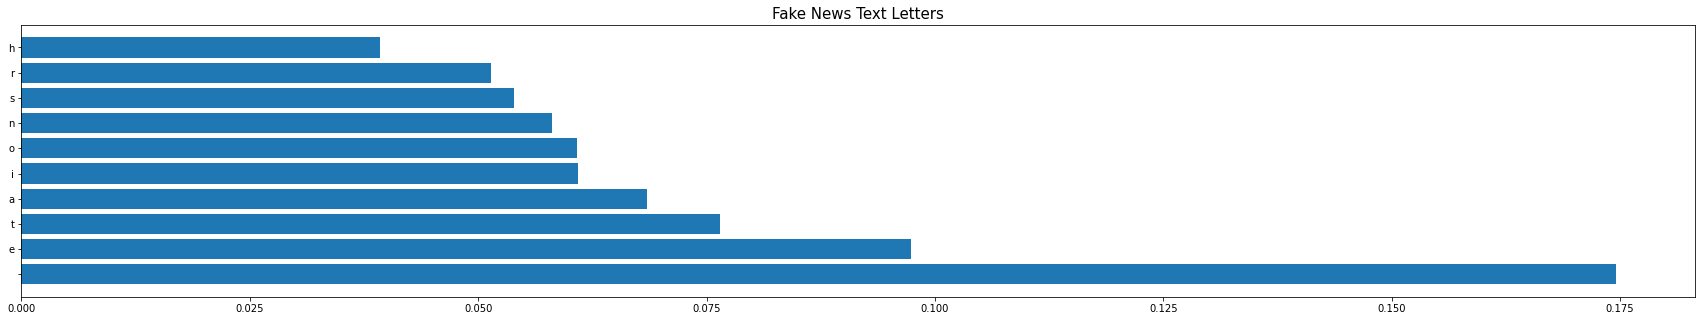

In [ ]:

#true
true_df_copy=true_df
num=0

letterdict={}
for row in true_df_copy['title']:
  for letter in row:
    num+=1
    if letter not in letterdict.keys():
      letterdict[letter]=0
    else:
      letterdict[letter]+=1
for i in letterdict.keys():
  letterdict[i]=letterdict[i]/num
letterdict




#graph
d=Counter(letterdict)

fig,ax = plt.subplots()
fig.set_size_inches(30,5)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)

plt.title('True News Title Letters', fontsize=15)
plt.barh(*zip(*d.most_common(10)))

plt.show()  

#fake
fake_df_copy=fake_df
num=0
letterdict={}
for row in fake_df_copy['title']:
  for letter in row:
    num+=1
    if letter not in letterdict.keys():
      letterdict[letter]=0
    else:
      letterdict[letter]+=1
for i in letterdict.keys():
  letterdict[i]=letterdict[i]/num


#graph
d=Counter(letterdict)

fig,ax = plt.subplots()
fig.set_size_inches(30,5)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)

plt.title('Fake News Title Letters', fontsize=15)
plt.barh(*zip(*d.most_common(10)))

plt.show()  



num=0
letterdict={}
for row in true_df_copy['text']:
  for letter in row:
    num+=1
    if letter not in letterdict.keys():
      letterdict[letter]=0
    else:
      letterdict[letter]+=1
for i in letterdict.keys():
  letterdict[i]=letterdict[i]/num

#graph
d=Counter(letterdict)

fig,ax = plt.subplots()
fig.set_size_inches(30,5)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)

plt.title('True News Text Letters', fontsize=15)
plt.barh(*zip(*d.most_common(10)))

plt.show()  

num=0
letterdict={}
for row in fake_df_copy['text']:
  for letter in row:
    num+=1
    if letter not in letterdict.keys():
      letterdict[letter]=0
    else:
      letterdict[letter]+=1
for i in letterdict.keys():
  letterdict[i]=letterdict[i]/num

#graph
d=Counter(letterdict)

fig,ax = plt.subplots()
fig.set_size_inches(30,5)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)

plt.title('Fake News Text Letters', fontsize=15)
plt.barh(*zip(*d.most_common(10)))

plt.show()  



1.2.c
Κάνουμε split κάθε title/text και αυξάνουμε τον μετρητή κατά τον αριθμό των λέξεων.

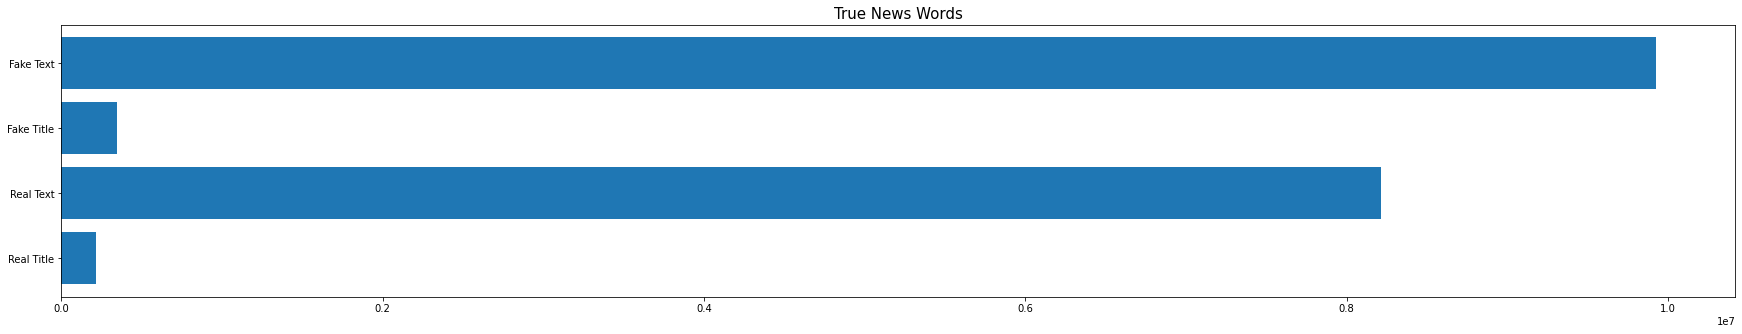

In [ ]:
#true
true_df_temp=true_df
num1=0
for i in range(len(true_df_temp['title'])):
  num1+=len(true_df_temp.iloc[i,0].split())
  
num2=0
for i in range(len(true_df_temp['text'])):
  num2+=len(true_df_temp.iloc[i,1].split())

#fake
fake_df_temp=fake_df
num3=0
for i in range(len(fake_df_temp['title'])):
  num3+=len(fake_df_temp.iloc[i,0].split())
num4=0
for i in range(len(fake_df_temp['text'])):
  num4+=len(fake_df_temp.iloc[i,1].split())

#graph
numarray=[num1,num2,num3,num4]
numarraytxt=['Real Title','Real Text','Fake Title','Fake Text']

fig,ax = plt.subplots()
fig.set_size_inches(30,5)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)
plt.title('True News Words', fontsize=15)
plt.barh(numarraytxt,numarray)
plt.show()  


1.2.d
Κάνουμε split κάθε title/text και αυξάνουμε τον μετρητή κατά τον αριθμό των λέξεων αφαιρώντας τα stopwords.

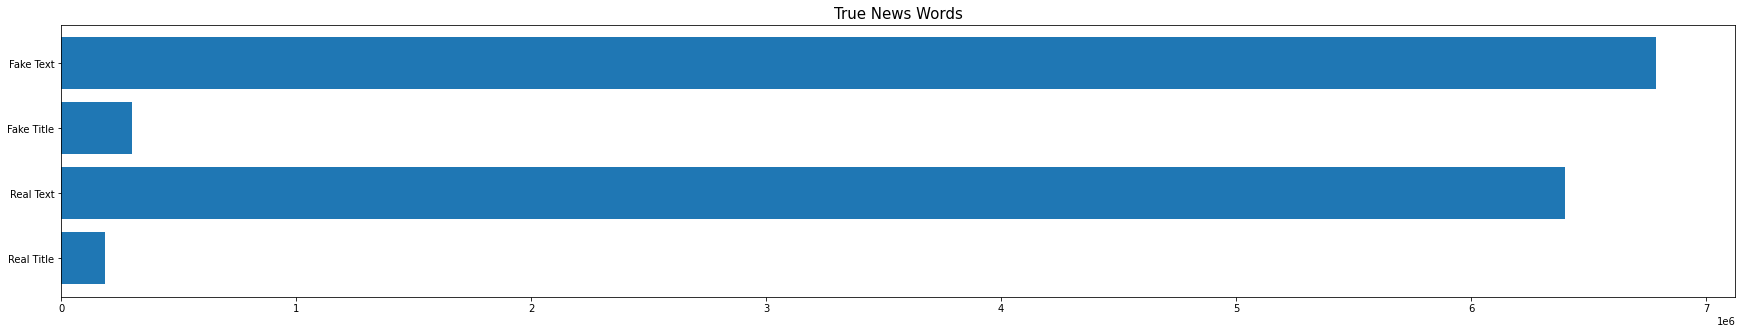

In [ ]:
#true
stopwords = ['the','of','a','and','to','in','on','as','an','for','is','^']
true_df_temp=true_df
num1=0
for i in range(len(true_df_temp['title'])):
  temp1=true_df_temp.iloc[i,0].split()
  for j in temp1:
    if j not in stopwords:
      num1+=1


num2=0
for i in range(len(true_df_temp['text'])):
  temp2=true_df_temp.iloc[i,1].split()
  for j in temp2:
    if j not in stopwords:
      num2+=1
#fake
fake_df_temp=fake_df
num3=0
for i in range(len(fake_df_temp['title'])):
  temp3=fake_df_temp.iloc[i,0].split()
  for j in temp3:
    if j not in stopwords:
      num3+=1

num4=0
for i in range(len(true_df_temp['text'])):
  temp4=fake_df_temp.iloc[i,1].split()
  for j in temp4:
    if j not in stopwords:
      num4+=1


numarray=[num1,num2,num3,num4]
numarraytxt=['Real Title','Real Text','Fake Title','Fake Text']

fig,ax = plt.subplots()
fig.set_size_inches(30,5)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)
plt.title('True News Words', fontsize=15)
plt.barh(numarraytxt,numarray)
plt.show()


1.2.e
Χρησιμοποιούμε τους vectorizers από την προηγούμενη εργασία για να χωρίσουμε τα titles/text σε bigrams, από τα οποία κρατάμε τα 20 πιο συνήθη.

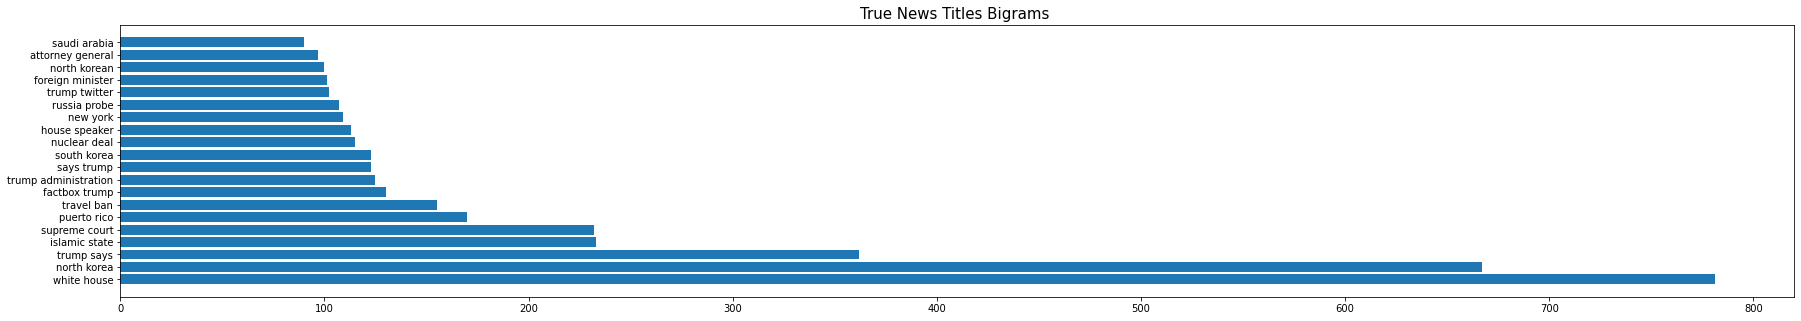

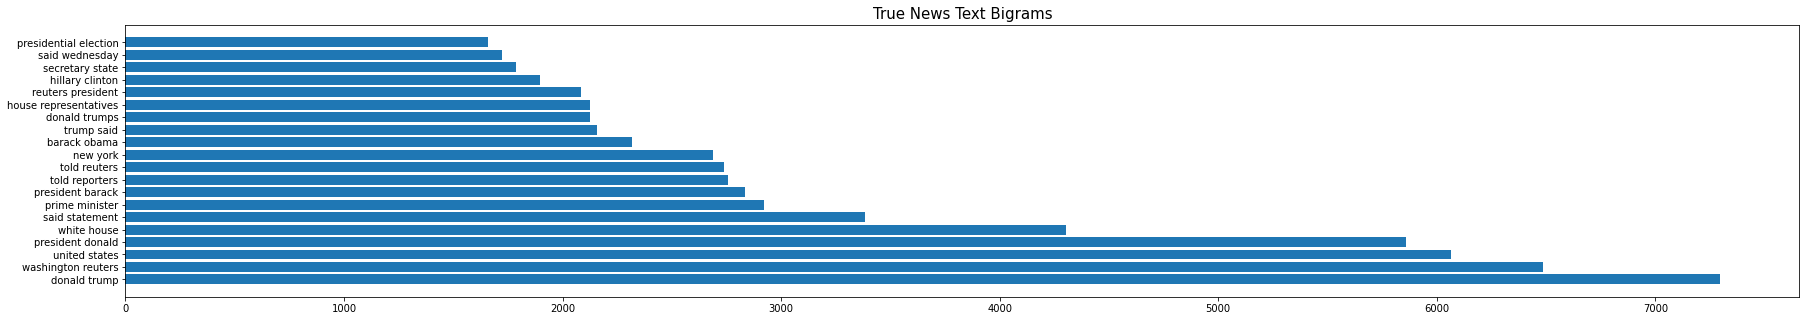

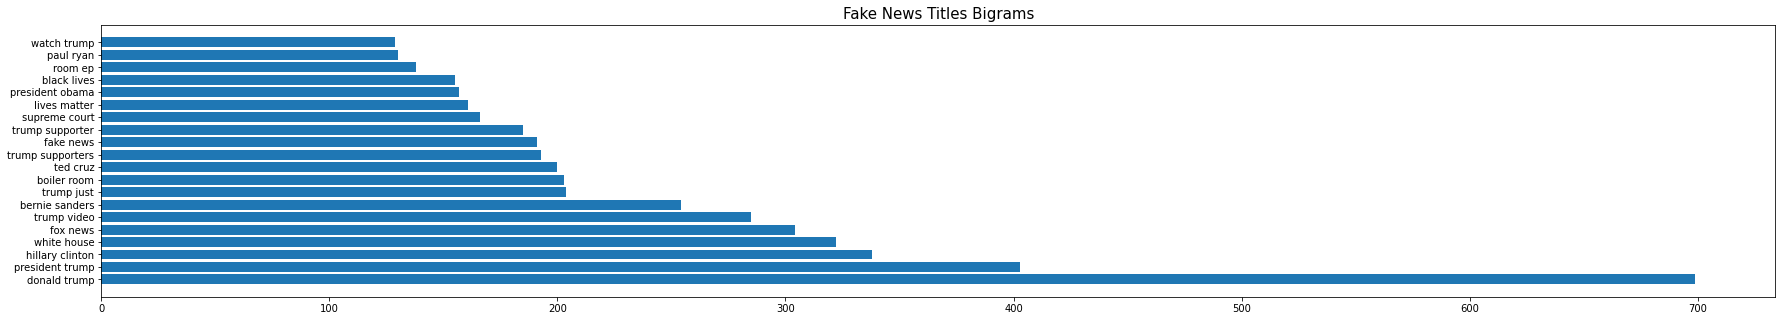

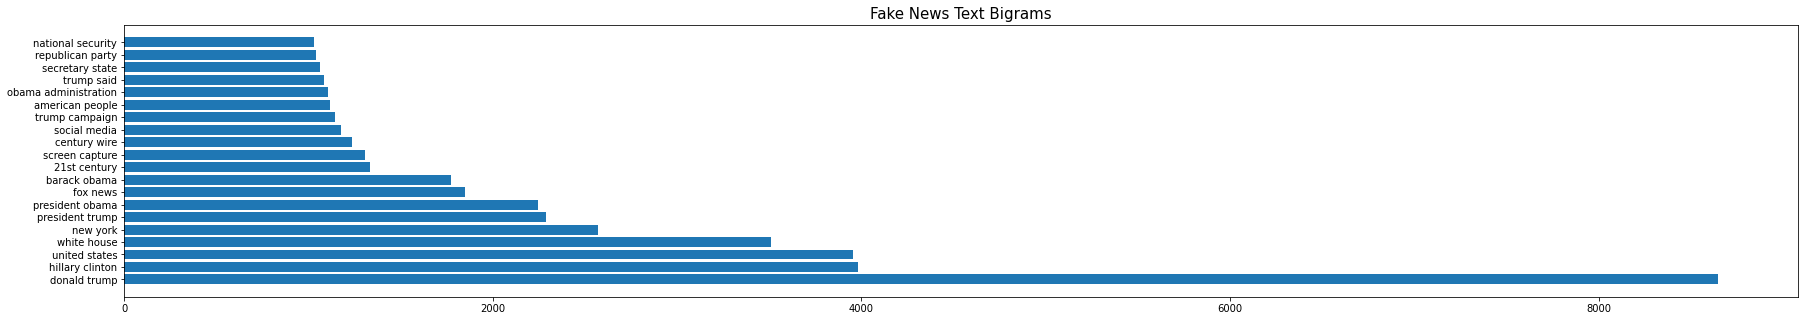

In [ ]:
#true


mystr=[]
for i in true_df['title']:
  mystr.append(i)
vectorizer = CountVectorizer(stop_words='english',analyzer='word', ngram_range=(2, 2),binary=True)
vec = vectorizer.fit(mystr)
bag_of_words = vec.transform(mystr)
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

#graph
fig,ax = plt.subplots()
fig.set_size_inches(30,5)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)

plt.title('True News Titles Bigrams ', fontsize=15)
plt.barh(*zip(*words_freq[:20]))
plt.show() 


mystr=[]
for i in true_df['text']:
  mystr.append(i)
vectorizer2 = CountVectorizer(stop_words='english',analyzer='word', ngram_range=(2, 2),binary=True)
vec = vectorizer2.fit(mystr)
bag_of_words = vec.transform(mystr)
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

#graph
fig,ax = plt.subplots()
fig.set_size_inches(30,5)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)

plt.title('True News Text Bigrams', fontsize=15)
plt.barh(*zip(*words_freq[:20]))
plt.show() 



#fake
mystr=[]
for i in fake_df['title']:
  mystr.append(i)
vectorizer3 = CountVectorizer(stop_words='english',analyzer='word', ngram_range=(2, 2),binary=True)
vec = vectorizer3.fit(mystr)
bag_of_words = vec.transform(mystr)
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

#graph
fig,ax = plt.subplots()
fig.set_size_inches(30,5)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)

plt.title('Fake News Titles Bigrams', fontsize=15)
plt.barh(*zip(*words_freq[:20]))
plt.show() 


mystr=[]
for i in fake_df['text']:
  mystr.append(i)
vectorizer4 = CountVectorizer(stop_words='english',analyzer='word', ngram_range=(2, 2),binary=True)
vec = vectorizer4.fit(mystr)
bag_of_words = vec.transform(mystr)
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

#graph
fig,ax = plt.subplots()
fig.set_size_inches(30,5)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)

plt.title('Fake News Text Bigrams', fontsize=15)
plt.barh(*zip(*words_freq[:20]))
plt.show() 


1.3

Δημιουργούμε τις test και train databases



In [ ]:
dftrain_true = true_df[:1000] 
dftrain_true.insert(4,"label",1)
dftrain_fake = fake_df[:1000] 
dftrain_fake.insert(4,"label",0)
dftrain_true = dftrain_true.reset_index(drop=True)
dftrain_fake = dftrain_fake.reset_index(drop=True)
dftrain = pd.concat([dftrain_true,dftrain_fake], axis=0,ignore_index=True)
dftrain.to_csv(r'/content/gdrive/MyDrive/DICources/Train.csv',index=False)

dftest_true = true_df[17851:]
dftest_true.insert(4,"label",1)
dftest_fake = fake_df[17851:] 
dftest_fake.insert(4,"label",0)
dftest_true = dftest_true.reset_index(drop=True)
dftest_fake = dftest_fake.reset_index(drop=True)
dftest = pd.concat([dftest_true,dftest_fake], axis=0,ignore_index=True)
dftest.to_csv(r'/content/gdrive/MyDrive/DICources/Test.csv',index=False)

2.1

Παίρνωντας τις 300 πιο συνήθεις λέξεις από τον CountVectorizer δημιουργούμε πίνακα 300 επί τον αριθμό των title και text του training data, μετρώντας πόσες φορές εμφανίζεται η κάθε λέξη στο κείμενο για το training, καθώς και το testing.Χρησιμοποιούμε τους πίνακες αυτούς μαζί με τα labels και τα εισάγουμε σε κάθε αλγόριθμο.

Παρατηρούμε ότι με Logistic Regression έχουμε την καλύτερη απόδοση, ενώ ο Random Forests παράγει χαμηλότερα ποσοστά. Αυτά τα αποτελέσματα δεν είναι απολύτως αντιπροσωπευτικά των αποτελεσμάτων της θεωρίας, αφού δεν χρησιμοποιούνται οι παράμετροι στους αλγορίθμους.





In [ ]:
trainlabel = np.asarray(dftrain['label'])
traindata = np.asarray(dftrain['text'])
testlabel = np.asarray(dftest['label'])
testdata = np.asarray(dftest['text'])

newvectorizer = CountVectorizer( ngram_range=(1, 1),analyzer='word',binary=False,min_df=0.0016)
newgram = newvectorizer.fit_transform(traindata)
newgram1=newgram.toarray()

counts = pd.DataFrame(newgram.toarray(),columns=newvectorizer.get_feature_names())
mycounts=counts.sum()


myxvar=pd.DataFrame()
for i in range(300):
  myxvar[mycounts.sort_values(ascending=False).head(300).index[i]]=counts[mycounts.sort_values(ascending=False).head(300).index[i]]

newvectorizer = CountVectorizer( ngram_range=(1, 1),analyzer='word',binary=False,min_df=0.0016)
newgram = newvectorizer.fit_transform(testdata)
newgram1=newgram.toarray()

counts = pd.DataFrame(newgram.toarray(),columns=newvectorizer.get_feature_names())
mycounts=counts.sum()


myyvar=pd.DataFrame()
for i in range(300):
  myyvar[mycounts.sort_values(ascending=False).head(300).index[i]]=counts[mycounts.sort_values(ascending=False).head(300).index[i]]


model = LogisticRegression(max_iter=20000)
model.fit(myxvar,trainlabel)
print("Logic Regression:\naccuracy: ",model.score(myyvar,testlabel))
predicted=model.predict(myyvar)
print("f1 score :",f1_score(testlabel, predicted, average='macro'))


gnb = GaussianNB()
y_pred = gnb.fit(myxvar, trainlabel)
print("\nGaussianNB:\naccuracy: ",gnb.score(myyvar,testlabel))
predicted=gnb.predict(myyvar)
print("f1 score :",f1_score(testlabel, predicted, average='macro'))


parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
cfc = svm.SVC()
clf = GridSearchCV(cfc, parameters)
clf.fit(myxvar, trainlabel)
print("\nSupport Vector machine:\naccuracy: ",clf.score(myyvar,testlabel))
predicted=clf.predict(myyvar)
print("f1 score :",f1_score(testlabel, predicted, average='macro'))


cls = RandomForestClassifier(max_depth=2, random_state=0)
cls.fit(myxvar, trainlabel)
print("\nRandom forests:\naccuracy :",cls.score(myyvar,testlabel))
predicted=cls.predict(myyvar)
print("f1 score :",f1_score(testlabel, predicted, average='macro'))




Logic Regression:
accuracy:  0.5994997825141366
f1 score : 0.5994821593611699

GaussianNB:
accuracy:  0.5765550239234449
f1 score : 0.5586948995658528

Support Vector machine:
accuracy:  0.5825358851674641
f1 score : 0.5818986899605726

Random forests:
accuracy : 0.5419747716398434
f1 score : 0.5412401171361341


Παίρνωντας τις 300 πιο συνήθεις λέξεις από τον TfidfVectorizer δημιουργούμε πίνακα 300 επί τον αριθμό των title και text του training data, μετρώντας πόσες φορές εμφανίζεται η κάθε λέξη στο κείμενο για το training, καθώς και το testing.Χρησιμοποιούμε τους πίνακες αυτούς μαζί με τα labels και τα εισάγουμε σε κάθε αλγόριθμο.

In [ ]:
newvectorizer = TfidfVectorizer(ngram_range=(1, 1),analyzer='word',binary=False,min_df=0.0016)
newgram = newvectorizer.fit_transform(traindata)
newgram1=newgram.toarray()

counts = pd.DataFrame(newgram.toarray(),columns=newvectorizer.get_feature_names())
mycounts=counts.sum()


myxvar=pd.DataFrame()
for i in range(300):
  myxvar[mycounts.sort_values(ascending=False).head(300).index[i]]=counts[mycounts.sort_values(ascending=False).head(300).index[i]]

newvectorizer = TfidfVectorizer( ngram_range=(1, 1),analyzer='word',binary=False,min_df=0.0016)
newgram = newvectorizer.fit_transform(testdata)
newgram1=newgram.toarray()

counts = pd.DataFrame(newgram.toarray(),columns=newvectorizer.get_feature_names())
mycounts=counts.sum()


myyvar=pd.DataFrame()
for i in range(300):
  myyvar[mycounts.sort_values(ascending=False).head(300).index[i]]=counts[mycounts.sort_values(ascending=False).head(300).index[i]]

print("TF/IDF")

model = LogisticRegression()
model.fit(myxvar,trainlabel)
print("Logic Regression:\naccuracy: ",model.score(myyvar,testlabel))
predicted=model.predict(myyvar)
print("f1 score :",f1_score(testlabel, predicted, average='macro'))


gnb = GaussianNB()
y_pred = gnb.fit(myxvar, trainlabel)
print("\nGaussianNB:\naccuracy: ",gnb.score(myyvar,testlabel))
predicted=gnb.predict(myyvar)
print("f1 score :",f1_score(testlabel, predicted, average='macro'))


parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
cfc = svm.SVC()
clf = GridSearchCV(cfc, parameters)
clf.fit(myxvar, trainlabel)
print("\nSupport Vector machine:\naccuracy: ",clf.score(myyvar,testlabel))
predicted=clf.predict(myyvar)
print("f1 score :",f1_score(testlabel, predicted, average='macro'))


cls = RandomForestClassifier(max_depth=2, random_state=0)
cls.fit(myxvar, trainlabel)
print("\nRandom forests:\naccuracy :",cls.score(myyvar,testlabel))
predicted=cls.predict(myyvar)
print("f1 score :",f1_score(testlabel, predicted, average='macro'))

TF/IDF
Logic Regression:
accuracy:  0.4019138755980861
f1 score : 0.40092297990655545

GaussianNB:
accuracy:  0.5219660722053067
f1 score : 0.4894126575635267

Support Vector machine:
accuracy:  0.44464984775989563
f1 score : 0.44256047164321444

Random forests:
accuracy : 0.49206176598521095
f1 score : 0.47667172919830747


2.2

Αρχικά κάνουμε train και φτιάχουμε λεξικό στο word2vec και δημιουργούμε πίνακα 300 x αριθμός κειμένων. Στη συνέχεια, για κάθε λέξη προσθέτουμε τον counter του word2vec στη λίστα.

Στο τέλος χρησιμοποιούμε τον πίνακα αυτό με τα labels, εκτελώντας κάθε αλγόριθμο. 

Παρατηρούμε παρόμοια αποτελέσματα με τον vectorizer.

In [ ]:
tokens=dftrain["text"]
tokenize=[i.split() for i in tokens]
w2vmodel = Word2Vec(tokenize,size=300,min_count=1)
w2vmodel.build_vocab(tokenize,update=True)  # prepare the model vocabulary
w2vmodel.train(tokenize, total_examples=w2vmodel.corpus_count, epochs=5) # train the model
print(w2vmodel.wv.index2word)
glove_vectors = api.load("glove-wiki-gigaword-100")



['the', 'to', 'a', 'of', 'and', 'in', 'that', 'trump', 'on', 'for', 'is', 'he', 's', 'it', 'said', 'his', 'with', 'was', 'as', 'has', 'by', 'not', 'be', 'have', 'this', 'from', 'us', 'at', 'are', 'who', 'would', 'they', 'president', 'but', 'an', 'about', 'i', 'house', 'tax', 'you', 'we', 'donald', 'will', 't', 'their', 'had', 'people', 'or', 'been', 'white', 'republican', 'if', 'more', 'were', 'senate', 'which', 'one', 'all', 'out', 'after', 'when', 'bill', 'him', 'also', 'just', 'up', 'what', 'no', 'republicans', 'new', 'reuters', 'over', 'can', 'there', 'she', 'so', 'than', 'washington', 'campaign', 'could', 'like', 'do', 'its', 'even', 'states', 'because', 'other', 'now', 'time', 'former', 'her', 'state', 'some', 'percent', 'into', 'our', 'told', 'against', 'any', 'them', 'should', 'did', 'trumps', 'via', 'image', 'news', 'while', 'first', 'congress', 'last', 'only', 'year', 'election', 'russia', 'get', 'united', 'before', 'how', 'government', 'administration', 'two', 'federal', 'ru

In [ ]:
templist=[[0]*300]*len(tokens)
i=0
for text in tokenize:
  for word in text:
    if word in w2vmodel.wv.index2word:
      templist[i]+=w2vmodel.wv[word]
  i+=1


In [ ]:
model = LogisticRegression(max_iter=2000)
model.fit(templist,trainlabel)
print("Logic Regression:\naccuracy: ",model.score(myyvar,testlabel))
predicted=model.predict(myyvar)
print("f1 score :",f1_score(testlabel, predicted, average='macro'))


gnb = GaussianNB()
y_pred = gnb.fit(templist, trainlabel)
print("\nGaussianNB:\naccuracy: ",gnb.score(myyvar,testlabel))
predicted=gnb.predict(myyvar)
print("f1 score :",f1_score(testlabel, predicted, average='macro'))


parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
cfc = svm.SVC()
clf = GridSearchCV(cfc, parameters)
clf.fit(templist, trainlabel)
print("\nSupport Vector machine:\naccuracy: ",clf.score(myyvar,testlabel))
predicted=clf.predict(myyvar)
print("f1 score :",f1_score(testlabel, predicted, average='macro'))


cls = RandomForestClassifier(max_depth=2, random_state=0)
cls.fit(templist, trainlabel)
print("\nRandom forests:\naccuracy :",cls.score(myyvar,testlabel))
predicted=cls.predict(myyvar)
print("f1 score :",f1_score(testlabel, predicted, average='macro'))


Logic Regression:
accuracy:  0.38777729447585907
f1 score : 0.2794232878859113

GaussianNB:
accuracy:  0.38777729447585907
f1 score : 0.2794232878859113

Support Vector machine:
accuracy:  0.38777729447585907
f1 score : 0.2794232878859113

Random forests:
accuracy : 0.38777729447585907
f1 score : 0.2794232878859113


Bonus

Χρησιμοποιούμε τις εντολές preprocessing για να κάνουμε standardize τα δεδομένα και στη συνέχεια τα κανονικοποιούμε μέσω της εντολής normalize.

Εφόσον τα δεδομένα είναι πιο ενοποιημένα η ακρίβεια αυξάνεται.

In [ ]:


trainlabel = np.asarray(dftrain['label'])
traindata = np.asarray(dftrain['text'])
testlabel = np.asarray(dftest['label'])
testdata = np.asarray(dftest['text'])

newvectorizer = CountVectorizer( ngram_range=(1, 1),analyzer='word',binary=False,min_df=0.0016)
newgram = newvectorizer.fit_transform(traindata)
newgram1=newgram.toarray()

counts = pd.DataFrame(newgram.toarray(),columns=newvectorizer.get_feature_names())
mycounts=counts.sum()


myxvar=pd.DataFrame()
for i in range(1300):
  myxvar[mycounts.sort_values(ascending=False).head(1300).index[i]]=counts[mycounts.sort_values(ascending=False).head(1300).index[i]]

newvectorizer = CountVectorizer(ngram_range=(1, 1),analyzer='word',binary=False,min_df=0.0016)
newgram = newvectorizer.fit_transform(testdata)
newgram1=newgram.toarray()

counts = pd.DataFrame(newgram.toarray(),columns=newvectorizer.get_feature_names())
mycounts=counts.sum()


myyvar=pd.DataFrame()
for i in range(1300):
  myyvar[mycounts.sort_values(ascending=False).head(1300).index[i]]=counts[mycounts.sort_values(ascending=False).head(1300).index[i]]

#preprocessing standartisation
scaler = preprocessing.StandardScaler().fit(myxvar)
xscaled= scaler.transform(myxvar) 
xscaled_normalized = preprocessing.normalize(xscaled, norm='l2')



model = LogisticRegression(max_iter=2000)
model.fit(xscaled_normalized,trainlabel)
print("Logic Regression:\naccuracy: ",model.score(myyvar,testlabel))
predicted=model.predict(myyvar)
print("f1 score :",f1_score(testlabel, predicted, average='macro'))

Logic Regression:
accuracy:  0.6342975206611571
f1 score : 0.5689306203384296
